In [1]:
from train_util import get_annotation

%load_ext autoreload
%autoreload 2

In [2]:
import os
src_ap_path = os.path.join('..','KneeQualityAssurance', 'data', 'Data','ap','xiangya_png_all')
img_list = os.listdir(src_ap_path)

In [2]:
#visually check some of the results
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode
from train_util import get_annotation
import os
import numpy as np
from collections import Counter
import time
import cv2
import random
import matplotlib.pyplot as plt
%matplotlib inline

MetadataCatalog.get("knee").thing_classes = ["knee"]


cfg = get_cfg()
cfg.merge_from_file('./configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml')
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 
output_dirs = ['AP_2020_05_06_18_25_35_fold1','AP_2020_05_06_20_07_44_fold2','AP_2020_05_06_21_50_10_fold3']
knee_ap_metadata = MetadataCatalog.get("knee")
predictors = {}

for i in range(len(output_dirs)):
    cfg.OUTPUT_DIR = output_dirs[i]
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
    predictor_name = 'predictor_fold{}'.format(i+1)
    predictors[predictor_name] = DefaultPredictor(cfg)   

# Check prediction result visually

In [6]:
import os
target_path = os.path.join('Xiangya_AP_result')
colors = ['r', 'g', 'b']
color_dict = {key: colors[i] for i, key in enumerate(predictors.keys())} 

for i, img_fn in enumerate(img_list):
# for img_fn in random.sample(img_list, 1):
    if not img_fn.endswith('.png'):
        continue
    img_path = os.path.join(src_ap_path, img_fn)
    im = cv2.imread(img_path)
    outputs = {}
    bboxes = []
    preds = []
    assigned_colors = []
    for p in predictors.keys():
        outputs[p] = predictors[p](im)
        bbox = outputs[p]["instances"].pred_boxes.to("cpu").tensor.squeeze().numpy()
        pred = outputs[p]["instances"].pred_classes.to("cpu").numpy()
        bboxes.append(bbox)
        preds.extend([str(i) for i in pred])
        assigned_colors.extend([color_dict[p] for i in range(len(outputs[p]["instances"]))])
    
    
    v = Visualizer(im[:, :, ::-1],
                   metadata=knee_ap_metadata, 
                   scale=0.8
    )
    print('Processing image {}: {}'.format(i, img_fn))
    print(np.vstack(bboxes))
    print(preds)
    img_pred =  v.overlay_instances(boxes = np.vstack(bboxes),
                                      labels =preds,
                                      assigned_colors=assigned_colors)    
    # plt.imshow(img_pred.get_image())
    save_path = os.path.join(target_path, img_fn)
    cv2.imwrite(save_path, img_pred.get_image())

Processing image 0: 0007684732_001_R.png
[[ 198.74687  731.2136  1086.0122  1843.3229 ]
 [ 214.29768  755.34814 1091.9437  1834.1531 ]
 [ 209.861    747.6162  1087.7338  1835.5387 ]]
['0', '0', '0']
Processing image 1: 0007752309_002_L.png
[[ 191.96217 1127.6342  1141.0443  2211.0974 ]
 [ 174.1907  1133.7532  1157.4481  2223.9834 ]
 [ 177.53172 1142.8923  1156.8837  2198.9907 ]]
['0', '0', '0']
Processing image 2: 0007715666_001_L.png
[[ 773.64594 1091.962   1764.0499  2132.4731 ]
 [ 788.1637  1070.372   1731.2649  2161.199  ]
 [ 758.461   1045.7506  1757.5804  2176.4683 ]]
['0', '0', '0']
Processing image 3: 0007218363_001_R.png
[[ 590.287   1119.8573  1595.3234  2246.9924 ]
 [ 580.11847 1127.1213  1598.2576  2268.8098 ]
 [ 599.2477  1116.7013  1601.5764  2267.6323 ]]
['0', '0', '0']
Processing image 4: 0006835603_001_R.png
[[ 705.677   995.3459 1580.1567 2032.5449]
 [ 699.624   981.3173 1595.2651 2043.5947]
 [ 708.2569  990.32   1573.7327 2043.5607]]
['0', '0', '0']
Processing image 

In [5]:
# Create a labeling file
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog
from train_util import get_annotation
import os
import numpy as np
import time
import cv2
cfg = get_cfg()
cfg.merge_from_file('./configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml')
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8 
error_list = []
cfg.OUTPUT_DIR = 'AP_2020_05_06_21_50_10_fold3'
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0019999.pth")

predictor = DefaultPredictor(cfg)
result_txt = 'test_predicted_ap_xiangya_all_june_3_fold3.txt'
f = open(result_txt, 'w')
count = 0
for img_fn in img_list:
    if not img_fn.endswith('.png'):
        continue
    count = count+1
    img_path = os.path.join(src_ap_path, img_fn)
    im = cv2.imread(img_path)
    im = cv2.imread(img_path, flags = cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
    if len(im.shape) < 3:
        im = np.repeat(im[:, :, np.newaxis], 3, axis=2)
    outputs = predictor(im)     
    try:
        num_pred_boxes = len(outputs)
        if num_pred_boxes == 1:
            bbox = outputs['instances'].pred_boxes.to("cpu").tensor.squeeze().numpy()
        else:
            print('{} detected multiple boxes'.format(img_fn))
            scores = outputs['instances'].scores.to("cpu").numpy()
            bboxs = outputs['instances'].pred_boxes.to("cpu").tensor.squeeze().numpy()
            bbox = bboxs[np.argmax(scores)]
    except:
        print('No boxes detected')
        bbox = [-1,-1,-1,-1]
    bbox = outputs["instances"].pred_boxes.to("cpu").tensor.squeeze().numpy()
    preds = outputs["instances"].pred_classes.to("cpu").numpy()
        
    [x1, y1, x2, y2] = bbox
    rowtxt = '{},{},{},{},{}'.format(img_fn, int(x1), int(y1), int(x2), int(y2))
    print(str(count) + ": " + rowtxt)    

    f.write(rowtxt)
    f.write('\n')

f.close()


1: 0007684732_001_R.png,209,747,1087,1835
2: 0007752309_002_L.png,177,1142,1156,2198
3: 0007715666_001_L.png,758,1045,1757,2176
4: 0007218363_001_R.png,599,1116,1601,2267
5: 0006835603_001_R.png,708,990,1573,2043
6: 0007698135_001_R.png,741,606,1712,1689
7: 0007596599_002_L.png,186,758,1132,1854
8: 0002064947_001_R.png,388,502,1364,1539
9: 0007731068_001_R.png,175,1291,1024,2346
10: 0007677445_001_R.png,90,444,999,1594
11: 0007120269_002_L.png,0,691,997,1864
12: 0006003958_001_R.png,380,637,1235,1681
13: 0007726868_001_R.png,20,520,874,1708
14: 0007767143_001_R.png,227,999,1111,2107
15: 0007691551_001_R.png,596,1026,1637,2168
16: 0007614883_001_R.png,571,626,1610,1817
17: 0007740962_001_L.png,445,849,1653,2110
18: 0007723979_001_R.png,82,678,899,1644
19: 0003862037_004_L.png,714,1020,1579,1942
20: 0007764685_001_R.png,754,1087,1706,2067
21: 0007539881_001_R.png,891,998,1852,2028
22: 0003966294_001_R.png,154,875,1061,1903
23: 0007753896_001_L.png,204,770,1064,1740
24: 0007754556_003_L.p

In [1]:
# Create a labeling file
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog
from train_util import get_annotation
import os
import numpy as np
import time
import cv2
cfg = get_cfg()
cfg.merge_from_file('./configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml')
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8 
error_list = []
cfg.OUTPUT_DIR = 'AP_2020_05_06_21_50_10_fold3'
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0019999.pth")

predictor = DefaultPredictor(cfg)

src_ap_path = os.path.join('..','KneeQualityAssurance', 'data', 'Data','ap','xiangya_png_all')
img_list = os.listdir(src_ap_path)
img_fn = '0007687871_002_L.png'
img_path = os.path.join(src_ap_path, img_fn)
im = cv2.imread(img_path, flags = cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
if len(im.shape) < 3:
    im = np.repeat(im[:, :, np.newaxis], 3, axis=2)
outputs = predictor(im)     
try:
    num_pred_boxes = len(outputs)
    if num_pred_boxes == 1:
        bbox = outputs['instances'].pred_boxes.to("cpu").tensor.squeeze().numpy()
    else:
        print('{} detected multiple boxes'.format(img_fn))
        scores = outputs['instances'].scores.to("cpu").numpy()
        bboxs = outputs['instances'].pred_boxes.to("cpu").tensor.squeeze().numpy()
        bbox = bboxs[np.argmax(scores)]
except:
    print('No boxes detected')
    bbox = [-1,-1,-1,-1]
bbox = outputs["instances"].pred_boxes.to("cpu").tensor.squeeze().numpy()
preds = outputs["instances"].pred_classes.to("cpu").numpy()

[x1, y1, x2, y2] = bbox
rowtxt = '{},{},{},{},{}'.format(img_fn, int(x1), int(y1), int(x2), int(y2))
print(rowtxt)    

NameError: name 'count' is not defined

In [2]:
print(rowtxt)

0007687871_002_L.png,577,1344,1589,2457


{'instances': Instances(num_instances=1, image_height=3056, image_width=2468, fields=[pred_boxes: Boxes(tensor([[ 577.2291, 1344.6366, 1589.6317, 2457.1265]], device='cuda:0')), scores: tensor([1.0000], device='cuda:0'), pred_classes: tensor([0], device='cuda:0')])}


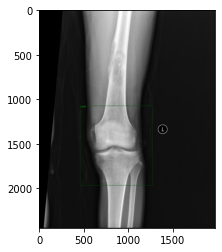

In [3]:
import random
import time
import matplotlib.pyplot as plt
import numpy as np
import cv2
%matplotlib inline
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode
knee_ap_metadata = MetadataCatalog.get("knee")

v = Visualizer(im[:, :, ::-1],
               metadata=knee_ap_metadata, 
               scale=0.8
)
print(outputs)
# img_gt = v.draw_dataset_dict(d)   
img_pred_gt = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(cv2.cvtColor(img_pred_gt.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))

# LAT

In [1]:
import os
src_lat_path = os.path.join('..','KneeQualityAssurance', 'data', 'Data','lat','xiangya_png_all')
img_list = os.listdir(src_lat_path)

In [7]:
#visually check some of the results
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode
from train_util import get_annotation
import os
import numpy as np
from collections import Counter
import time
import cv2
import random
import matplotlib.pyplot as plt
%matplotlib inline

MetadataCatalog.get("knee").thing_classes = ["knee"]


cfg = get_cfg()
cfg.merge_from_file('./configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml')
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 
knee_lat_metadata = MetadataCatalog.get("knee")
error_list = []
cfg.OUTPUT_DIR = 'LAT_2020_04_14_10_15_54'
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0019999.pth")

predictor = DefaultPredictor(cfg)

src_lat_path = os.path.join('..','KneeQualityAssurance', 'data', 'Data','lat','xiangya_png_all')
img_list = os.listdir(src_lat_path)
count = 0

target_path = os.path.join('Xiangya_LAT_result')
for img_fn in img_list:
    if not img_fn.endswith('.png'):
        continue
    count = count+1
    img_path = os.path.join(src_lat_path, img_fn)
    im = cv2.imread(img_path, flags = cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
    if len(im.shape) < 3:
        im = np.repeat(im[:, :, np.newaxis], 3, axis=2)
    outputs = predictor(im)    
    
    v = Visualizer(im[:, :, ::-1],
                   metadata=knee_lat_metadata, 
                   scale=0.8
                )
    
    img_pred = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    
    save_path = os.path.join(target_path, img_fn)
    cv2.imwrite(save_path, img_pred.get_image())


In [4]:
#visually check some of the results
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode
from train_util import get_annotation
import os
import numpy as np
from collections import Counter
import time
import cv2
import random
import matplotlib.pyplot as plt
%matplotlib inline

MetadataCatalog.get("knee").thing_classes = ["knee"]


cfg = get_cfg()
cfg.merge_from_file('./configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml')
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 
knee_ap_metadata = MetadataCatalog.get("knee")
error_list = []
cfg.OUTPUT_DIR = 'LAT_2020_04_14_10_15_54'
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0019999.pth")

predictor = DefaultPredictor(cfg)

src_lat_path = os.path.join('..','KneeQualityAssurance', 'data', 'Data','lat','xiangya_png_all')
img_list = os.listdir(src_lat_path)
count = 0
result_txt = 'test_predicted_lat_xiangya_all_june_3_withmetalmodel.txt'
f = open(result_txt, 'w')

for img_fn in img_list:
    if not img_fn.endswith('.png'):
        continue
    count = count+1
    img_path = os.path.join(src_lat_path, img_fn)
    im = cv2.imread(img_path, flags = cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
    if len(im.shape) < 3:
        im = np.repeat(im[:, :, np.newaxis], 3, axis=2)
    outputs = predictor(im)     
    try:
        num_pred_boxes = len(outputs)
        if num_pred_boxes == 1:
            bbox = outputs['instances'].pred_boxes.to("cpu").tensor.squeeze().numpy()
        else:
            print('{} detected multiple boxes'.format(img_fn))
            scores = outputs['instances'].scores.to("cpu").numpy()
            bboxs = outputs['instances'].pred_boxes.to("cpu").tensor.squeeze().numpy()
            bbox = bboxs[np.argmax(scores)]
    except:
        print('No boxes detected')
        bbox = [-1,-1,-1,-1]
    bbox = outputs["instances"].pred_boxes.to("cpu").tensor.squeeze().numpy()
    preds = outputs["instances"].pred_classes.to("cpu").numpy()
        
    [x1, y1, x2, y2] = bbox
    rowtxt = '{},{},{},{},{}'.format(img_fn, int(x1), int(y1), int(x2), int(y2))
    print(str(count) + ": " + rowtxt)    

    f.write(rowtxt)
    f.write('\n')

f.close()
